### Imports et chargement des données

In [1]:
#imports
import numba
import os
import cv2
import tensorflow as tf; tf.compat.v1.disable_eager_execution() #avoid bug with disable eager
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import random
from tqdm import tqdm
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from PIL import Image
from plotly import tools
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly
from sklearn.model_selection import train_test_split
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

tf.executing_eagerly()

False

In [2]:
# load train and test dataset
def load_dataset(my_dir, size=(256,256)):
    images = []
    labels = []
    labels_names = []
    current_label = -1
    for i in os.listdir(my_dir):
        current_label += 1
        for file in os.listdir(my_dir+"\\"+i):
            if os.path.isfile(my_dir+"\\"+i+"\\"+file):
                #openimg + convert into numpy array + add to list
                #print("path : ", mydir+"\\"+i+"\\"+file)
                image = cv2.imread(my_dir+"\\"+i+"\\"+file, )
                image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = np.reshape(image, (size[0],size[1], 3))
                images.append(image)
                #print(current_label)
                labels.append(current_label)
                
            else:
                #current_label += 1
                labels_names.append(file)
                #print("current_label ", current_label)

    #convert data and labels to numpy arrays
    images = np.asarray(images)
    labels = np.asarray(labels)
    trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.2)
    trainY_no_categorical = trainY
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, testX, trainY, testY, labels_names, trainY_no_categorical

my_dir = os.getcwd()+"\\simpson\\simpsons_dataset"
trainX, testX, trainY, testY, labels_names, trainY_no_categorical = load_dataset(my_dir, (64,64))
print("trainX shape : ", trainX.shape)
print("trainY shape : ", trainY.shape)
print("labels names \n", labels_names)

# np.count_nonzero(trainY_no_categorical == 5)

trainX shape :  (16746, 64, 64, 3)
trainY shape :  (16746, 43)
labels names 
 ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


In [3]:
# preprocess pixels
def preprocess_pixels(trainX, testX):
    # convert from integers to floats
    trainX_norm = trainX.astype('float32')
    testX_norm = testX.astype('float32')
    # normalize to range 0-1
    trainX_norm = trainX_norm / 255.0
    testX_norm = testX_norm / 255.0
    # return normalized images
    return trainX_norm, testX_norm

trainX, testX = preprocess_pixels(trainX, testX)
print("trainX shape ", trainX.shape, "testX shape ", testX.shape)

trainX shape  (16746, 64, 64, 3) testX shape  (4187, 64, 64, 3)


### Recapitulatif des tests menés

In [4]:
#idee autres encoders / decoders


#test 1, Convs (16,8,8), loss = MSE + kl_loss, epochs 40, latent dim à 2

#         #create the encoder
#         encoder_input = keras.layers.Input(shape=(self.img_width, self.img_height, self.img_depth))
#         encoder_conv = keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(encoder_input)
#         encoder_conv = keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(encoder_conv)
#         encoder_conv = keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(encoder_conv)
#         encoder = keras.layers.Flatten()(encoder_conv)

#         z_mean = keras.layers.Dense(self.latent_dim)(encoder)
#         z_log_sigma = keras.layers.Dense(self.latent_dim)(encoder)
        
#         #function to determine values inside the latent space,
#         def determine_latent(x):
#             z_mean, z_log_sigma = x
#             batch = K.shape(z_mean)[0]
#             dim = K.int_shape(z_mean)[1]
#             eps = K.random_normal(shape=(batch,dim))
#             return z_mean + K.exp(z_log_sigma/2)*eps

#         #normalize to to sample data (reparametrization trick) (use Lambda layer to use arbitrary expression as layer)
#         latent_space = keras.layers.Lambda(determine_latent, output_shape=(self.latent_dim,))([z_mean, z_log_sigma])
        
#         #keep conv_shape for later use in decoder
#         conv_shape = K.int_shape(encoder_conv)
        

#         #create the decoder
#         decoder_input = keras.layers.Input(shape=(self.latent_dim,))
#         #use our conv shape variable
#         decoder = keras.layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
#         decoder = keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
#         decoder_conv = keras.layers.Conv2DTranspose(filters=8, kernel_size=3,
#                                    padding='same', activation='relu')(decoder)
#         decoder_conv = keras.layers.Conv2DTranspose(filters=8, kernel_size=3,
#                                    padding='same', activation='relu')(decoder_conv)
#         decoder_conv = keras.layers.Conv2DTranspose(filters=16, kernel_size=3, 
#                                    padding='same', activation='relu')(decoder_conv)
#         decoder_conv =  keras.layers.Conv2DTranspose(filters=self.img_depth, kernel_size=3, 
#                                   padding='same', activation='sigmoid')(decoder_conv)
    
        
        
#         #create the vae (encoder + decoder)
#         encoder = keras.Model(encoder_input, latent_space)
#         decoder = keras.Model(decoder_input, decoder_conv)
        
#         #keep encoder + decoder in class variable
#         self.encoder = encoder
#         self.decoder = decoder
        
#         self.vae = keras.Model(encoder_input, decoder(encoder(encoder_input)))
        
        
#         #create the reconstruction loss (combination with MSE)
#         def kl_reconstruction_loss(true, pred):
#             # Reconstruction loss
#             reconstruction_loss = keras.losses.MSE(K.flatten(true), K.flatten(pred)) * img_width * img_height
#             # KL divergence loss
#             kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
#             kl_loss = K.sum(kl_loss, axis=-1)
#             kl_loss *= -0.5
#             # Total loss = 50% rec + 50% KL divergence loss
#             return K.mean(reconstruction_loss + kl_loss)
        
        
#         #self.autoencoder.compile(loss=keras.losses.mse)
#         #compule the vae model (and use the kl_reconstruction_loss)
#         self.vae.compile(optimizer="adam", loss=kl_reconstruction_loss)


#test 2 = identique mais avec Binary crossentropy dans la loss à la place de MSE

#         #create the encoder
#         encoder_input = keras.layers.Input(shape=(self.img_width, self.img_height, self.img_depth))
#         encoder_conv = keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(encoder_input)
#         encoder_conv = keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(encoder_conv)
#         encoder_conv = keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(encoder_conv)
#         encoder = keras.layers.Flatten()(encoder_conv)

#         z_mean = keras.layers.Dense(self.latent_dim)(encoder)
#         z_log_sigma = keras.layers.Dense(self.latent_dim)(encoder)
        
#         #function to determine values inside the latent space,
#         def determine_latent(x):
#             z_mean, z_log_sigma = x
#             batch = K.shape(z_mean)[0]
#             dim = K.int_shape(z_mean)[1]
#             eps = K.random_normal(shape=(batch,dim))
#             return z_mean + K.exp(z_log_sigma/2)*eps

#         #normalize to to sample data (reparametrization trick) (use Lambda layer to use arbitrary expression as layer)
#         latent_space = keras.layers.Lambda(determine_latent, output_shape=(self.latent_dim,))([z_mean, z_log_sigma])
        
#         #keep conv_shape for later use in decoder
#         conv_shape = K.int_shape(encoder_conv)
        

#         #create the decoder
#         decoder_input = keras.layers.Input(shape=(self.latent_dim,))
#         #use our conv shape variable
#         decoder = keras.layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
#         decoder = keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
#         decoder_conv = keras.layers.Conv2DTranspose(filters=8, kernel_size=3,
#                                    padding='same', activation='relu')(decoder)
#         decoder_conv = keras.layers.Conv2DTranspose(filters=8, kernel_size=3,
#                                    padding='same', activation='relu')(decoder_conv)
#         decoder_conv = keras.layers.Conv2DTranspose(filters=16, kernel_size=3, 
#                                    padding='same', activation='relu')(decoder_conv)
#         decoder_conv =  keras.layers.Conv2DTranspose(filters=self.img_depth, kernel_size=3, 
#                                   padding='same', activation='sigmoid')(decoder_conv)
    
        
        
#         #create the vae (encoder + decoder)
#         encoder = keras.Model(encoder_input, latent_space)
#         decoder = keras.Model(decoder_input, decoder_conv)
        
#         #keep encoder + decoder in class variable
#         self.encoder = encoder
#         self.decoder = decoder
        
#         self.vae = keras.Model(encoder_input, decoder(encoder(encoder_input)))
        
        
#         #create the reconstruction loss (combination with MSE)
#         def kl_reconstruction_loss(true, pred):
#             # Reconstruction loss
#             reconstruction_loss = keras.losses.binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
#             # KL divergence loss
#             kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
#             kl_loss = K.sum(kl_loss, axis=-1)
#             kl_loss *= -0.5
#             # Total loss = 50% rec + 50% KL divergence loss
#             return K.mean(reconstruction_loss + kl_loss)
        
        
#         #self.autoencoder.compile(loss=keras.losses.mse)
#         #compule the vae model (and use the kl_reconstruction_loss)
#         self.vae.compile(optimizer="adam", loss=kl_reconstruction_loss)


#test 3 : comme test 1 mais pour un latent dim de 16

#test 4 : test avec des couches Dense, une couche 64 et une couche 32 (latent_dim à 2)
#         #create the encoder
#         encoder_input = keras.layers.Input(shape=(self.img_width, self.img_height, self.img_depth))
#         encoder_dense = keras.layers.Dense(64, activation='relu')(encoder_input)
#         encoder_dense = keras.layers.Dense(32, activation='relu')(encoder_dense)
#         encoder = keras.layers.Flatten()(encoder_dense)

#         z_mean = keras.layers.Dense(self.latent_dim)(encoder)
#         z_log_sigma = keras.layers.Dense(self.latent_dim)(encoder)
        
#         #function to determine values inside the latent space,
#         def determine_latent(x):
#             z_mean, z_log_sigma = x
#             batch = K.shape(z_mean)[0]
#             dim = K.int_shape(z_mean)[1]
#             eps = K.random_normal(shape=(batch,dim))
#             return z_mean + K.exp(z_log_sigma/2)*eps

#         #normalize to to sample data (reparametrization trick) (use Lambda layer to use arbitrary expression as layer)
#         latent_space = keras.layers.Lambda(determine_latent, output_shape=(self.latent_dim,))([z_mean, z_log_sigma])
        

#         #create the decoder
#         decoder_input = keras.layers.Input(shape=(self.latent_dim,))
#         decoder_dense = keras.layers.Dense(32, activation='relu')(decoder_input)
#         decoder_dense = keras.layers.Dense(64, activation="relu")(decoder_dense)
#         decoder_dense = keras.layers.Dense(self.img_dim, activation="sigmoid")(decoder_dense)
#         decoder_dense  = keras.layers.Reshape((self.img_width, self.img_height, self.img_depth))(decoder_dense)
    
        
#         #create the vae (encoder + decoder)
#         encoder = keras.Model(encoder_input, latent_space)
#         decoder = keras.Model(decoder_input, decoder_dense)
        
#         #keep encoder + decoder in class variable
#         self.encoder = encoder
#         self.decoder = decoder
        
#         self.vae = keras.Model(encoder_input, decoder(encoder(encoder_input)))
        
        
#         #create the reconstruction loss (combination with MSE)
#         def kl_reconstruction_loss(true, pred):
#             # Reconstruction loss
#             reconstruction_loss = keras.losses.MSE(K.flatten(true), K.flatten(pred)) * img_width * img_height
#             # KL divergence loss
#             kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
#             kl_loss = K.sum(kl_loss, axis=-1)
#             kl_loss *= -0.5
#             # Total loss = 50% rec + 50% KL divergence loss
#             return K.mean(reconstruction_loss + kl_loss)
        
        
#         #self.autoencoder.compile(loss=keras.losses.mse)
#         #compule the vae model (and use the kl_reconstruction_loss)
#         self.vae.compile(optimizer="adam", loss=kl_reconstruction_loss)

In [5]:
print("trainX shape ", trainX.shape)
print("trainY shape ", trainY.shape)

trainX shape  (16746, 64, 64, 3)
trainY shape  (16746, 43)


### Création de la classe "MyVAE"

In [6]:
#create the custom VAE class
class MyVAE:
    def __init__(self, img_width = 64, img_height = 64, img_depth = 3, latent_dim = 2):
        self.img_width = img_width
        self.img_height = img_height
        self.img_depth = img_depth
        self.img_dim = self.img_width * self.img_height * self.img_depth
        self.latent_dim = latent_dim # The dimension of the data embedding
        
        
        #create the encoder
        encoder_input = keras.layers.Input(shape=(self.img_width, self.img_height, self.img_depth))
        encoder_conv = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(encoder_input)
        encoder_conv = keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(encoder_conv)
        encoder = keras.layers.Flatten()(encoder_conv)

        z_mean = keras.layers.Dense(self.latent_dim)(encoder)
        z_log_sigma = keras.layers.Dense(self.latent_dim)(encoder)
        
        #function to determine values inside the latent space,
        def determine_latent(x):
            z_mean, z_log_sigma = x
            batch = K.shape(z_mean)[0]
            dim = K.int_shape(z_mean)[1]
            eps = K.random_normal(shape=(batch,dim))
            return z_mean + K.exp(z_log_sigma/2)*eps

        #normalize to to sample data (reparametrization trick) (use Lambda layer to use arbitrary expression as layer)
        latent_space = keras.layers.Lambda(determine_latent, output_shape=(self.latent_dim,))([z_mean, z_log_sigma])
        
        #keep conv_shape for later use in decoder
        conv_shape = K.int_shape(encoder_conv)
        

        #create the decoder
        decoder_input = keras.layers.Input(shape=(self.latent_dim,))
        #use our conv shape variable
        decoder = keras.layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
        decoder = keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
        decoder_conv = keras.layers.Conv2DTranspose(filters=16, kernel_size=3,
                                   padding='same', activation='relu')(decoder)
        decoder_conv = keras.layers.Conv2DTranspose(filters=32, kernel_size=3,
                                   padding='same', activation='relu')(decoder_conv)
#         decoder_conv = keras.layers.Conv2DTranspose(filters=16, kernel_size=3, 
#                                    padding='same', activation='relu')(decoder_conv)
        decoder_conv =  keras.layers.Conv2DTranspose(filters=self.img_depth, kernel_size=3, 
                                  padding='same', activation='sigmoid')(decoder_conv)
    
        
        
        #create the vae (encoder + decoder)
        encoder = keras.Model(encoder_input, latent_space)
        decoder = keras.Model(decoder_input, decoder_conv)
        
        #keep encoder + decoder in class variable
        self.encoder = encoder
        self.decoder = decoder
        
        self.vae = keras.Model(encoder_input, decoder(encoder(encoder_input)))
        
        
        #create the reconstruction loss (combination with MSE)
        def kl_reconstruction_loss(true, pred):
            # Reconstruction loss
            reconstruction_loss = keras.losses.MSE(K.flatten(true), K.flatten(pred)) * img_width * img_height * img_depth
            # KL divergence loss
            kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5
            # Total loss = 50% rec + 50% KL divergence loss
            return K.mean(reconstruction_loss + kl_loss)
        
        
        #self.autoencoder.compile(loss=keras.losses.mse)
        #compule the vae model (and use the kl_reconstruction_loss)
        self.vae.compile(optimizer="adam", loss=kl_reconstruction_loss)

        
        #self.autoencoder.summary()
    
    def fit(self, X, testX, n_epochs=20, n_batch_size=64):
        #self.autoencoder.compile(loss=keras.losses.mse)
        history = self.vae.fit(X, X, epochs=n_epochs, batch_size=n_batch_size, validation_data=(testX, testX))
        
        return history

    
    def plotLoss(self, model):
        
        def trace(x,y,imagesLabels,color):
            trace = go.Scatter(
                x = x,y = y,
                name=imagesLabels,
                marker=dict(color=color),
                mode = "markers+lines",
                text=x
            )
            return trace

        #hist = model
        hist = model.history
        loss = hist['loss']
        valLoss = hist['val_loss']

        epochs = list(range(1,len(loss)+1))

        traceL = trace(epochs,loss,"Training loss", "Blue")
        traceVl = trace(epochs,valLoss,"Validation loss", "Magenta")

        fig = plotly.subplots.make_subplots(rows=1,cols=1, subplot_titles=('Training and validation loss'))
        fig.append_trace(traceL,1,1)
        fig.append_trace(traceVl,1,1)
        fig['layout']['xaxis'].update(title = 'Epoch')
        fig['layout']['yaxis'].update(title = 'Loss', range=[0,60])


        iplot(fig, filename='loss')

### Verification des sorties de l'auto encoder, de l'encoder et du decoder (fixer latent_dim)

In [7]:
##### test vae
lat_dim = 2
my_vae = MyVAE(img_width = 64, img_height = 64, img_depth = 3, latent_dim = lat_dim)
# my_autoencoder.fit(trainX, 5, 200)
print("VAE predict shape")
print(my_vae.vae.predict(tf.zeros((10,64,64,3)), steps=1).shape)
print("VAE encoder predict shape")
print(my_vae.encoder.predict(tf.zeros((10,64,64,3)), steps=1).shape)
print("VAE decoder predict shape")
#for Dense layers
print(my_vae.decoder.predict(tf.zeros((1, lat_dim)), steps=1).shape)
#for conv layers (here 2 poolings)
#print(my_autoencoder.decoder.predict(tf.zeros((1,7, 7, lat_dim))).shape)

VAE predict shape


c:\users\arnau\anaconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



(10, 64, 64, 3)
VAE encoder predict shape
(10, 2)
VAE decoder predict shape
(1, 64, 64, 3)


In [8]:
#show models summary
my_vae.vae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
model (Functional)           (None, 2)                 267668    
_________________________________________________________________
model_1 (Functional)         (None, 64, 64, 3)         204435    
Total params: 472,103
Trainable params: 472,103
Non-trainable params: 0
_________________________________________________________________


In [9]:
my_vae.encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   4624        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 65536)        0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
my_vae.decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 65536)             196608    
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 16)        2320      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 3)         867       
Total params: 204,435
Trainable params: 204,435
Non-trainable params: 0
_____________________________________________________

### Entrainement de l'auto encoder

In [11]:
#fit auto encoder
history = my_vae.fit(trainX, testX, 40, 256)

Train on 16746 samples, validate on 4187 samples
Epoch 1/40
16746/16746 [==============================] - 9s 566us/sample - loss: 682.2589 - val_loss: 599.5995
Epoch 2/40
16746/16746 [==============================] - 7s 438us/sample - loss: 562.9523 - val_loss: 550.8881
Epoch 3/40
16746/16746 [==============================] - 7s 438us/sample - loss: 533.1439 - val_loss: 535.7342
Epoch 4/40
16746/16746 [==============================] - 7s 440us/sample - loss: 526.3126 - val_loss: 528.0308
Epoch 5/40
16746/16746 [==============================] - 7s 439us/sample - loss: 522.3428 - val_loss: 525.6093
Epoch 6/40
16746/16746 [==============================] - 7s 441us/sample - loss: 520.5061 - val_loss: 524.7052
Epoch 7/40
16746/16746 [==============================] - 7s 442us/sample - loss: 518.6544 - val_loss: 522.8074
Epoch 8/40
16746/16746 [==============================] - 7s 441us/sample - loss: 518.4662 - val_loss: 525.3591
Epoch 9/40
16746/16746 [==============================]

In [12]:
#plot loss evolution
my_vae.plotLoss(history)

### Affichage des données après compression

In [13]:
#compress trainX
compress_trainX = my_vae.encoder.predict(trainX)
print("compress trainX 0 shape : ", compress_trainX[0].shape)

compress trainX 0 shape :  (2,)


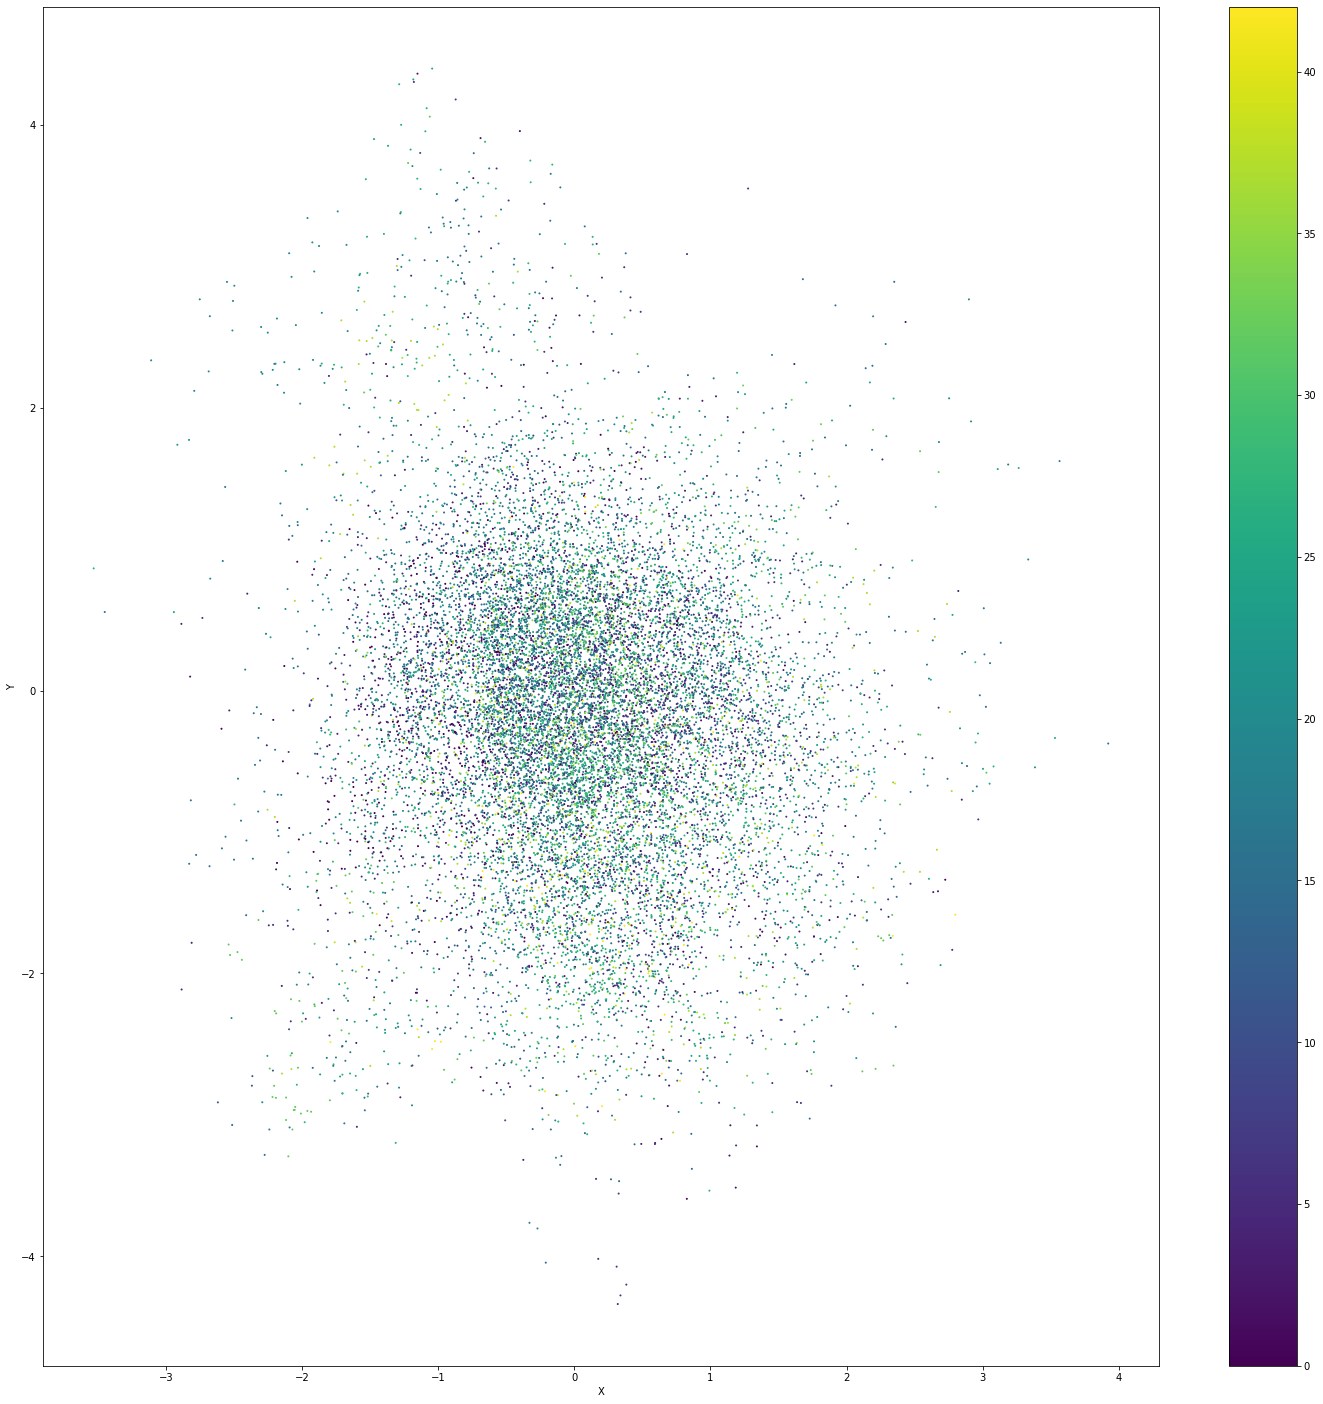

In [14]:
if lat_dim == 2:
    plot_compress_trainX = np.array(compress_trainX)
    plt.figure(figsize=(25, 25))
    plt.scatter(plot_compress_trainX[:, 0], plot_compress_trainX[:, 1], c=np.argmax(trainY, axis=1), s=1)
    plt.colorbar()
    plt.xlabel('X')
    plt.ylabel('Y')
#     plt.xlim(0, 60)
#     plt.ylim(0, 30)

### Génération de nouvelles images

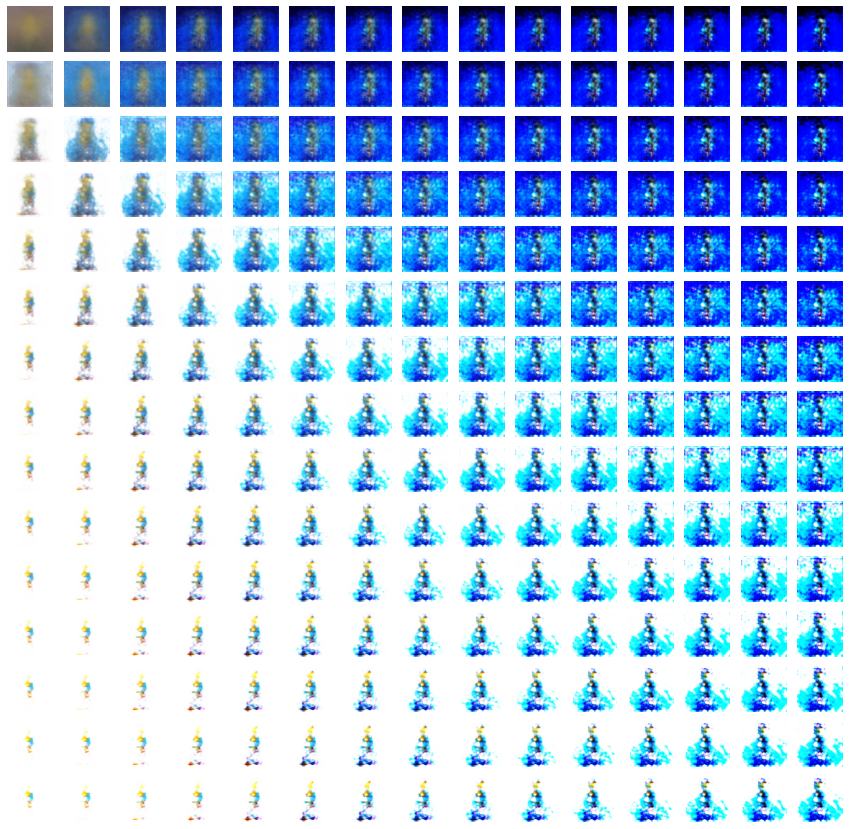

In [15]:
#real generation with random points
if lat_dim == 2:
    figure_size = 15  # figure with 5 x 5 images
    digit_size = 64
    #take figure_size points in range [0, 35] standard deviations for x and [0, 20] for y (for example, check the figure above)
    grid_x = np.linspace(0, 30, figure_size)
    grid_y = np.linspace(0, 30, figure_size)

    my_fig, my_ax = plt.subplots(figure_size, figure_size, figsize=(15,15))
    
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = my_vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size, 3)
            my_ax[i, j].imshow(digit)
            
    [axi.set_axis_off() for axi in my_ax.ravel()]
    plt.show()

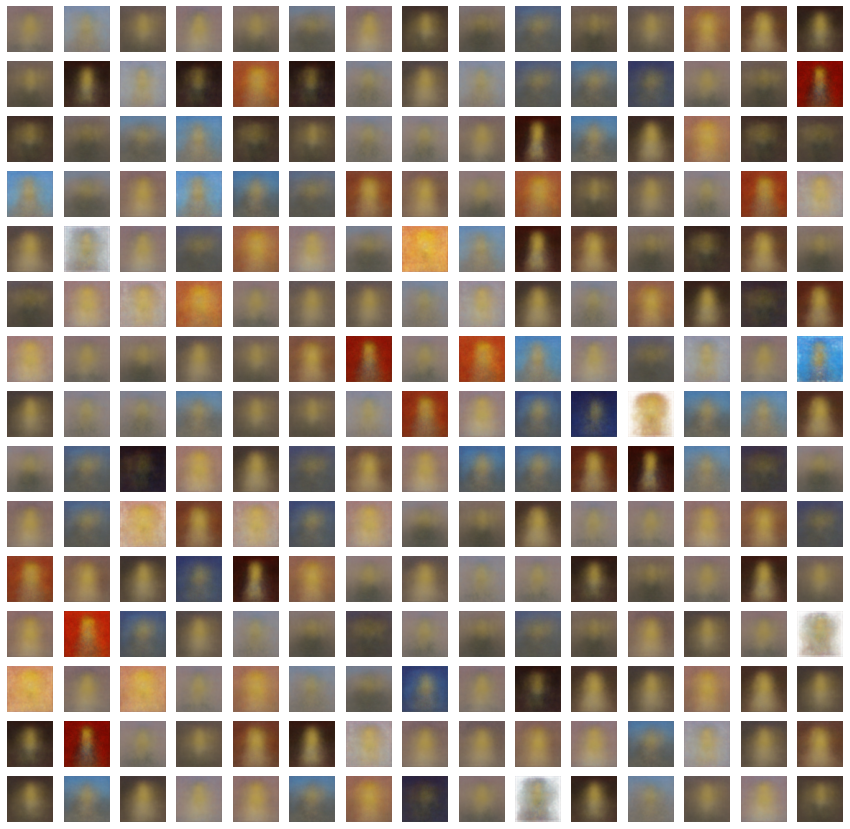

In [16]:
#version for all possibles latent dim ? ==> only take some random samples without x / y logic ( no gradient effect ;-( )

figure_size = 15  # figure with 15 x 15 images
digit_size = 64
#take figure_size points in range [0, 35] standard deviations for x and [0, 20] for y
my_range = np.floor(np.linspace(len(compress_trainX) // figure_size, len(compress_trainX), figure_size))

my_fig, my_ax = plt.subplots(figure_size, figure_size, figsize=(15,15))

begin_range = 0
for i, yi in enumerate(my_range):
    #take figure_size samples indexes in range (begin_range, yi)
    sample_indexes = [random.randint(begin_range, yi) for k in range(figure_size)]
    for j in range(len(sample_indexes)):
        x_decoded = my_vae.decoder.predict(np.expand_dims(compress_trainX[sample_indexes[j]], axis=0))
        digit = x_decoded[0].reshape(digit_size, digit_size, 3)
        my_ax[i, j].imshow(digit)

[axi.set_axis_off() for axi in my_ax.ravel()]
plt.show()

### Affichage des images originales et des images traitées par l'auto encoder (compress / decompress)

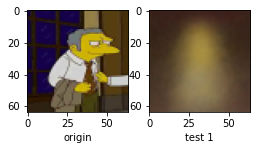

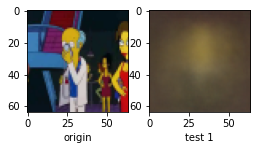

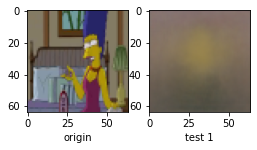

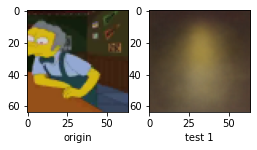

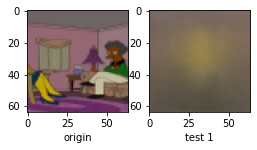

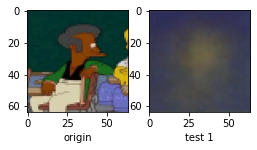

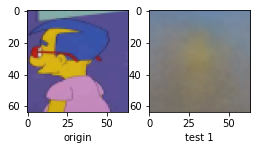

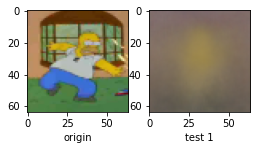

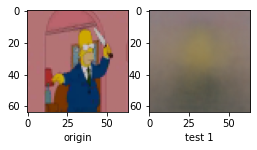

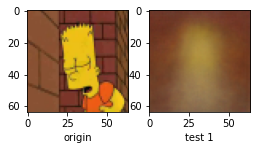

In [17]:
#plot 10 groups of samples for our test
for i in range(10):
    fig=plt.figure(figsize=(4, 4))
    columns = 2
    rows = 1
    
    r = random.randint(0, len(testX))

    fig.add_subplot(rows, columns, 1)
    plt.imshow(testX[r])#.squeeze(2), cmap="gray") # image orginal
    plt.xlabel("origin")

    fig.add_subplot(rows, columns, 2)
    test_1_img = my_vae.vae.predict(np.expand_dims(testX[r], axis=0))
    plt.imshow(test_1_img[0])#.squeeze(2), cmap="gray")
    plt.xlabel("test 1")

plt.show()